In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np

import warnings
warnings.filterwarnings("ignore")


import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import json

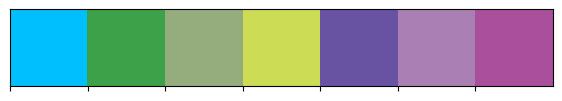

In [70]:
# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)

a = config['retrained_color_palette']

sns.palplot(sns.color_palette(a))



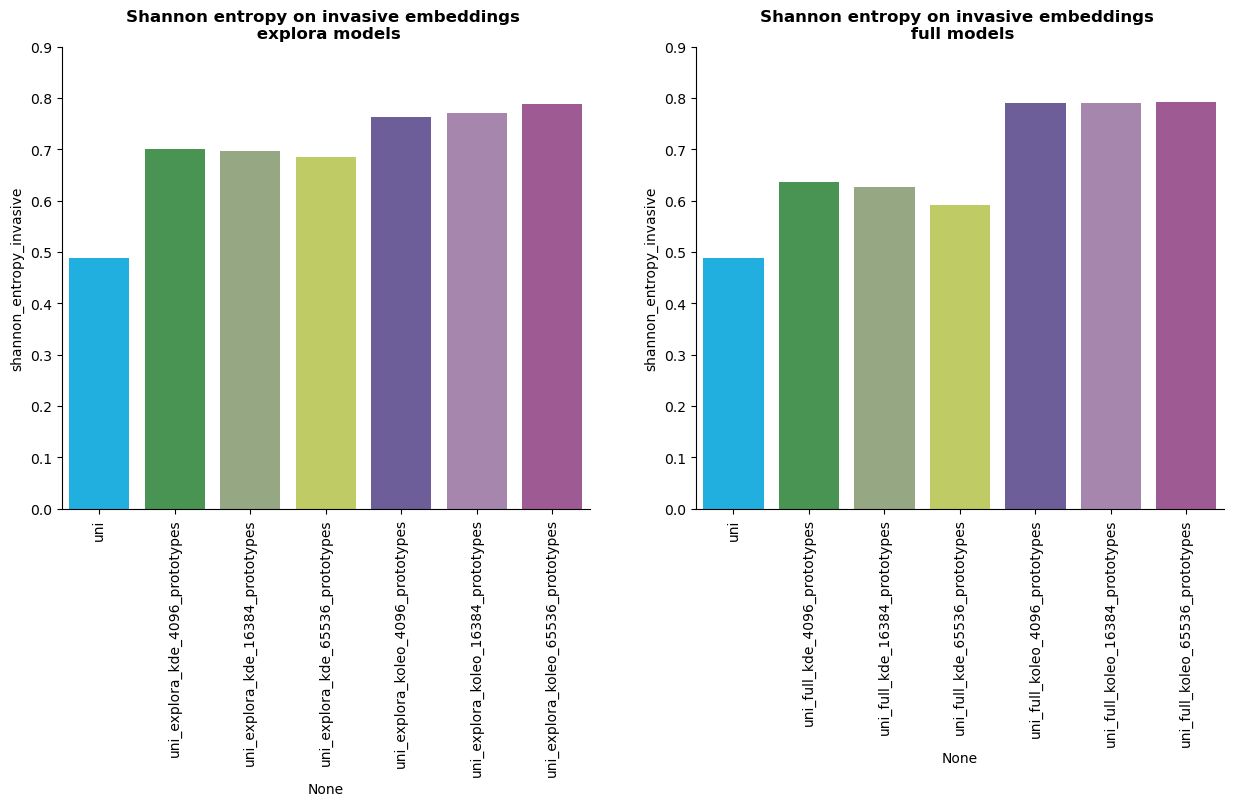

In [71]:
## Shannon entropy on invasive embeddings only
import json

plt.figure(figsize=(15, 6))
i = 0 

for model_type, path_to_pipelines, model_list in zip([config['retrained_model_list1_type'],
                                                      config['retrained_model_list2_type']],
                                                      [config['path_to_retrained_pipelines_1'],
                                                       config['path_to_retrained_pipelines_2']],
                                                       [config['retrained_model_list1'],
                                                        config['retrained_model_list2']]):
  


  entropies = {}
  for path, model in zip(path_to_pipelines, model_list):
      filename = os.path.join(path, "shannon_entropy", config['dataset'], "shannon_entropy.json")
      with open(filename) as f:
          entropies[model] = json.load(f)['whole_matrix']['raw_cancer_patches']

  df_entropy_invasive = pd.DataFrame.from_dict(entropies, orient='index')
  df_entropy_invasive.columns = ["shannon_entropy_invasive"]

  plt.subplot(1, 2, i + 1)
  sns.barplot(x=df_entropy_invasive.index, y=df_entropy_invasive["shannon_entropy_invasive"], palette=a)
  sns.despine()
  plt.xticks(rotation=90)
  plt.title(f"Shannon entropy on invasive embeddings \n {model_type} models", weight="bold")
  plt.ylim(0, 0.9)

  plt.savefig(os.path.join(config["figures_folder"], f"Figure3/shannon_entropy_invasive_{model_type}_models.pdf"), bbox_inches='tight')
  i += 1

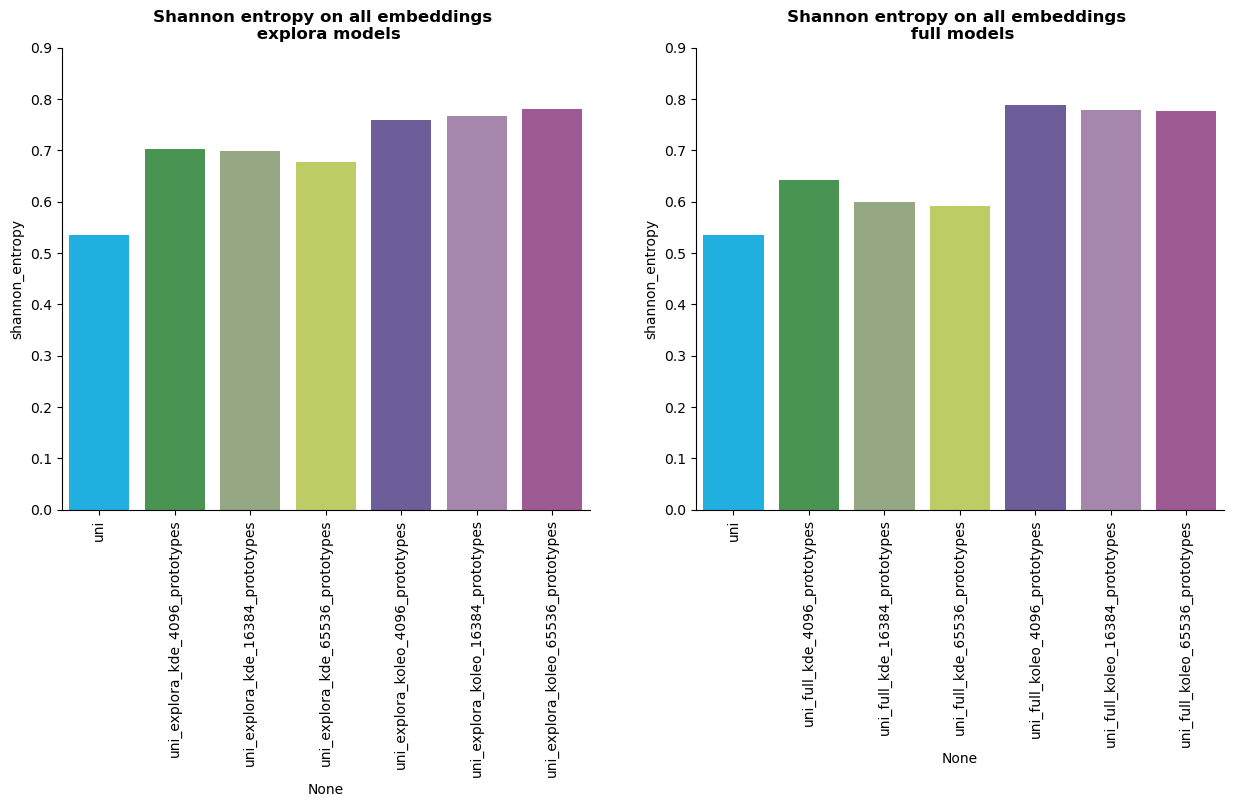

In [72]:
## Shannon entropy on whole embeddings 
import json

plt.figure(figsize=(15, 6))
i = 0 

for model_type, path_to_pipelines, model_list in zip([config['retrained_model_list1_type'],
                                                      config['retrained_model_list2_type']],
                                                      [config['path_to_retrained_pipelines_1'],
                                                       config['path_to_retrained_pipelines_2']],
                                                       [config['retrained_model_list1'],
                                                        config['retrained_model_list2']]):

  entropies = {}
  for path, model in zip(path_to_pipelines, model_list):
      filename = os.path.join(path, "shannon_entropy", config['dataset'], "shannon_entropy.json")
      with open(filename) as f:

          entropies[model] = json.load(f)['whole_matrix']['raw_all_patches']

  df_entropy = pd.DataFrame.from_dict(entropies, orient='index')
  df_entropy.columns = ["shannon_entropy"]

  plt.subplot(1, 2, i + 1)
  sns.barplot(x=df_entropy.index, y=df_entropy["shannon_entropy"], palette=a)
  sns.despine()
  plt.xticks(rotation=90)
  plt.title(f"Shannon entropy on all embeddings \n {model_type} models", weight="bold")
  plt.ylim(0, 0.9)
  i += 1

plt.savefig(os.path.join(config['figures_folder'], "Figure3", "shannon_entropy_retrained_models_whole_patches.pdf"),
            bbox_inches='tight')

In [73]:
entropies = {}

for model_type, path_to_pipelines, model_list in zip([config['retrained_model_list1_type'],
                                                      config['retrained_model_list2_type']],
                                                      [config['path_to_retrained_pipelines_1'],
                                                       config['path_to_retrained_pipelines_2']],
                                                       [config['retrained_model_list1'],
                                                        config['retrained_model_list2']]):

  for path, model in zip(path_to_pipelines, model_list):
      filename = os.path.join(path, "shannon_entropy", config['dataset'], "shannon_entropy.json")
      with open(filename) as f:

          entropies[model] = json.load(f)['whole_matrix']['raw_all_patches']

df_entropy = pd.DataFrame.from_dict(entropies, orient='index')

df_entropy.columns = ["shannon_entropy"]

In [74]:
import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

df_entropy = df_entropy.loc[sort_retrained_models(df_entropy.index)]


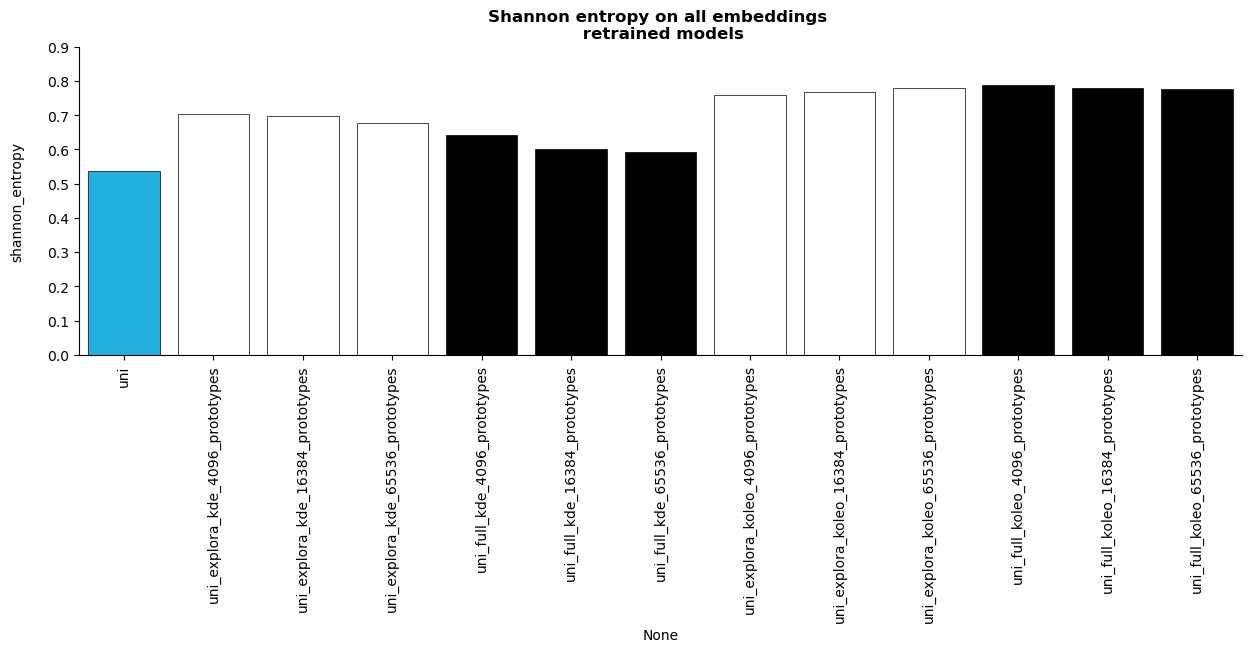

In [75]:
palette = []
for model in df_entropy.index:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

plt.figure(figsize=(15, 4))
sns.barplot(df_entropy, 
            x=df_entropy.index, 
            y="shannon_entropy", 
            palette=palette, 
            linewidth=0.5,
            edgecolor="black",
            )

plt.xticks(rotation=90)
sns.despine()

plt.title(f"Shannon entropy on all embeddings \n retrained models", weight="bold")
plt.ylim(0, 0.9)
plt.savefig(os.path.join(config['figures_folder'], "Figure3", "shannon_entropy_retrained_models.pdf"), 
            bbox_inches='tight')

## UMAP invasive cancer

In [103]:
import json

# This will give you the results for the full models
model_type=config['retrained_model_list2_type']

path = os.path.join(config['retrained_benchmark_folder2'], 'invasive_cancer_clustering', config['invasive_cancer_clustering_algo'])

names = config['retrained_model_list2']

## Create Figure 3 folder

if not os.path.exists(os.path.join(config['figures_folder'], "Figure3")):
    os.makedirs(os.path.join(config['figures_folder'], "Figure3"))

# UNCOMMENT THIS PART TO GET THE EXPLORA MODELS INSTEAD
# names = config['retrained_model_list1']
# model_type=config['retrained_model_list1_type']
# path = os.path.join(config['retrained_benchmark_folder1'], 'invasive_cancer_clustering', config['invasive_cancer_clustering_algo'])



In [104]:
path

'../../results/TNBC/benchmark/uni_full_models/invasive_cancer_clustering/kmeans'

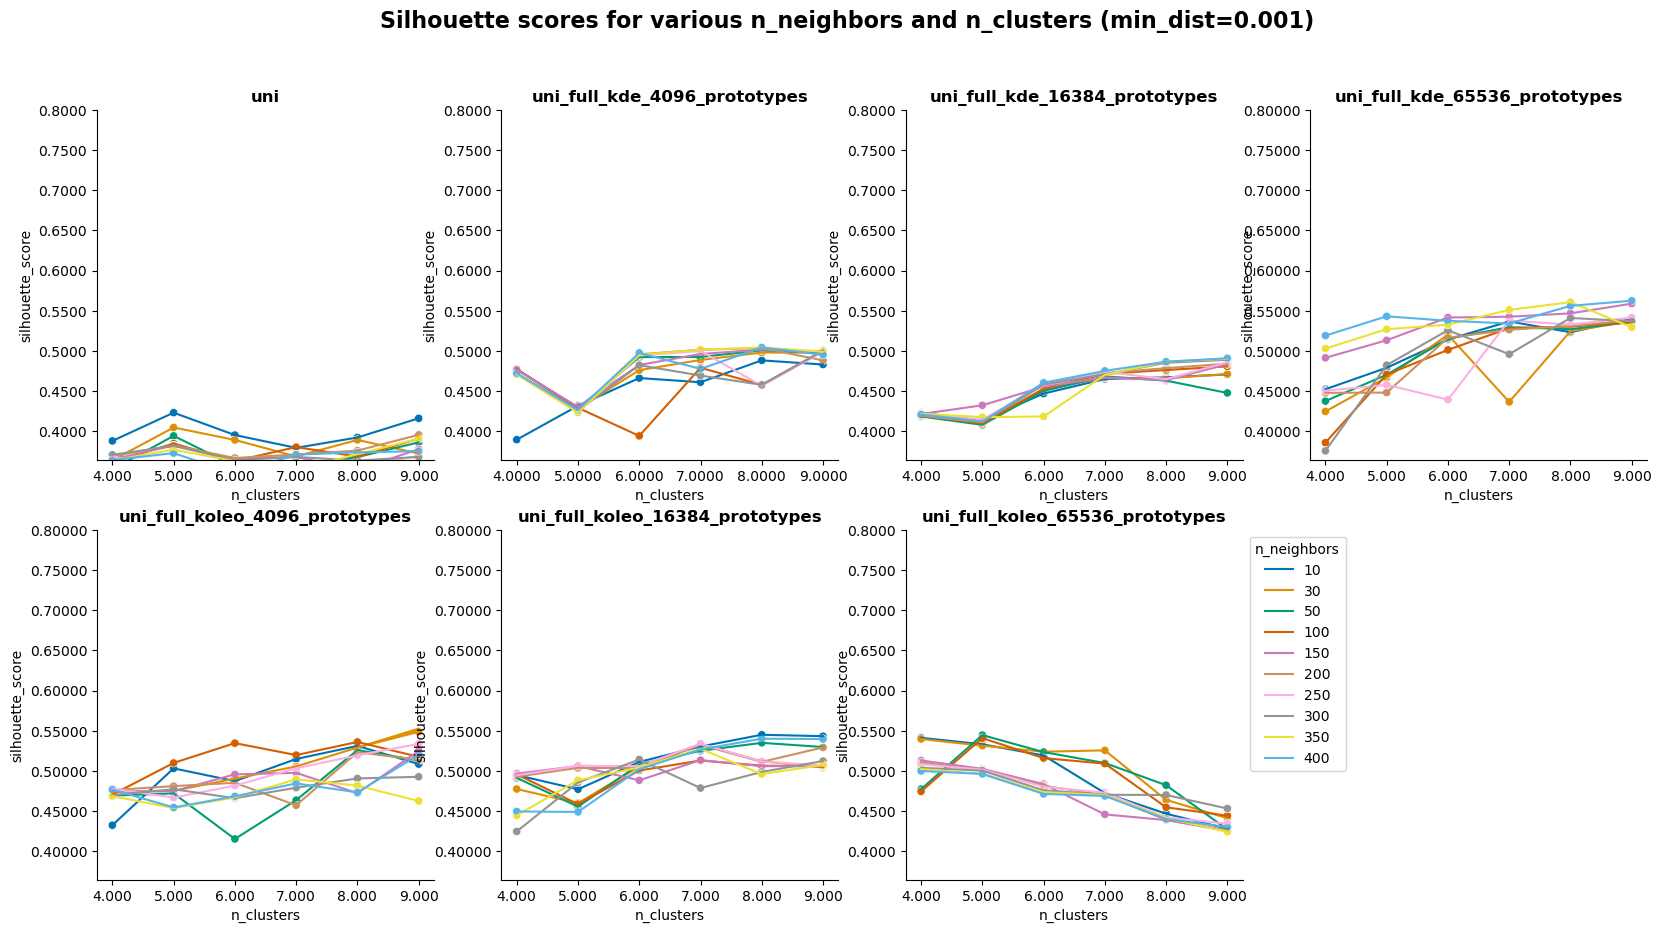

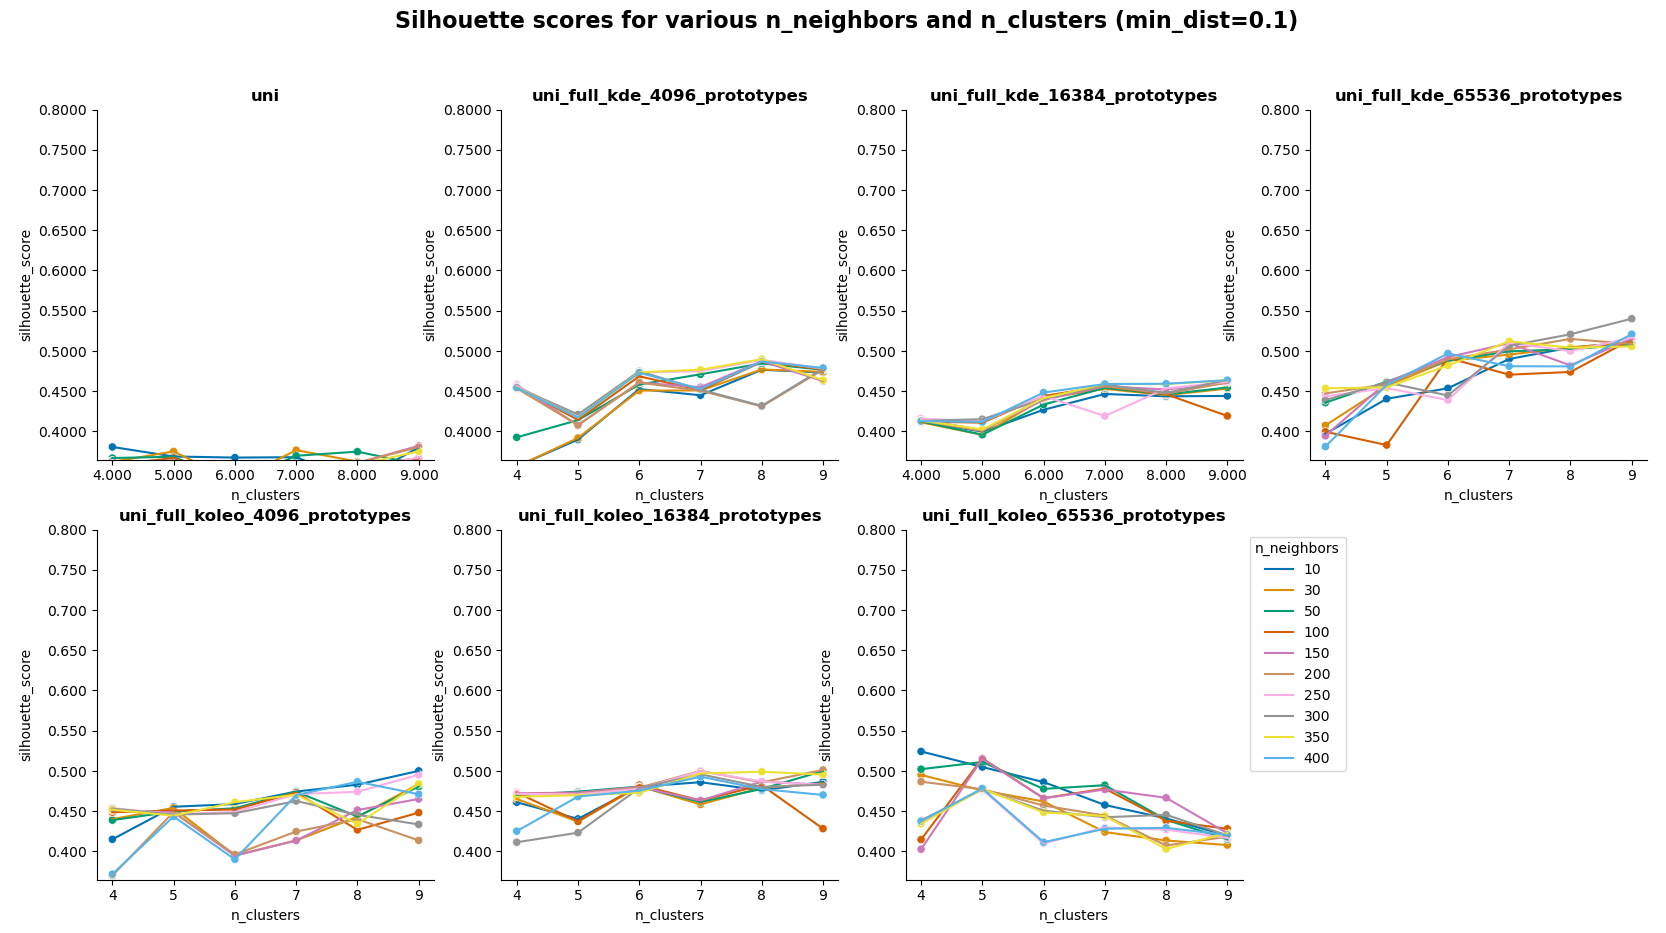

In [105]:
df_all_clusters = []

for min_dist in [0.001, 0.1]:
    plt.figure(figsize=(20, 10))
    for i, name in enumerate(names):
        plt.subplot(2, int(np.ceil(len(names)/2)), i + 1)
        dfs_clusters = []
        for k in [4, 5, 6, 7, 8, 9]:
        # for k in [5]:
            if os.path.exists(f"{path}/{name}/scores_umap_across_parameters_{k}_clusters.json"):
                # print(f"Trying to read {path}/{name}/scores_umap_across_parameters_{k}_clusters.json")
                
                with open(f"{path}/{name}/scores_umap_across_parameters_{k}_clusters.json", 'r') as f:
                    model_clusters = json.load(f)
                    
                    df_model_clusters = pd.DataFrame(model_clusters[str(min_dist)]).T
                    df_model_clusters = df_model_clusters.reset_index().rename(columns={"index": "n_neighbors"})
                    df_model_clusters["n_clusters"] = k
                    dfs_clusters.append(df_model_clusters)
            else:
                print(f"{path}/{name}/scores_umap_across_parameters_{k}_clusters.json does not exist")
                
        dfs_clusters = pd.concat(dfs_clusters)  
        dfs_clusters["name"] = name      
        df_all_clusters.append(dfs_clusters)

        sns.scatterplot(data=dfs_clusters, y="silhouette_score", x='n_clusters', hue='n_neighbors', palette='colorblind', legend=False)
        sns.lineplot(data=dfs_clusters, y="silhouette_score", x='n_clusters', hue='n_neighbors', palette='colorblind')
        sns.despine()

        plt.title(name, weight='bold')

        plt.suptitle(f"Silhouette scores for various n_neighbors and n_clusters (min_dist={min_dist})", 
                    weight='bold', 
                    fontsize=16)   
        
        
        if i != len(names) - 1:
            plt.legend().remove()
        else:
            plt.legend(title="n_neighbors", loc='upper left', bbox_to_anchor=(1, 1))
            
        plt.ylim(0.365, 0.8)
        
    plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"invasive_cancer_clustering_silhouette_scores_various_neighbors_mindist_{min_dist}_{model_type}_models.pdf"), bbox_inches='tight')

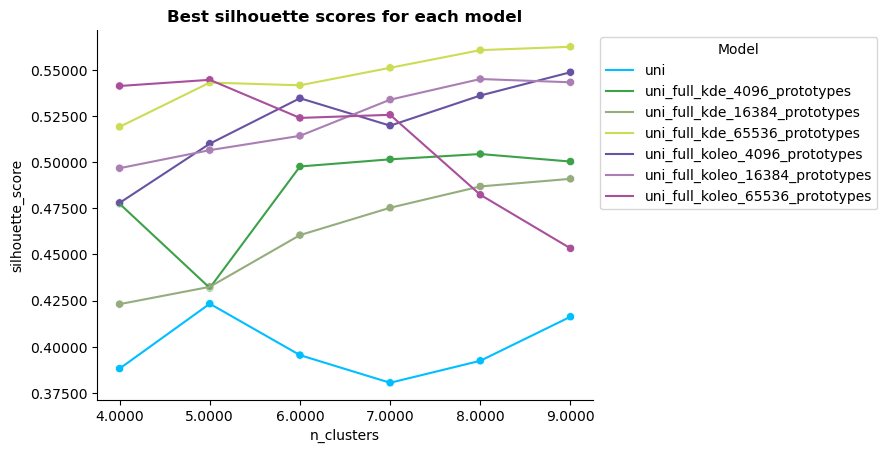

In [106]:
df_all = pd.concat(df_all_clusters)

best_silhouette_scores = df_all.groupby(["name", "n_clusters"])["silhouette_score"].max()
best_silhouette_scores_ordered = best_silhouette_scores.loc[names].reset_index()
sns.lineplot(data=best_silhouette_scores_ordered, x="n_clusters", y="silhouette_score", hue="name", palette=a)
sns.scatterplot(data=best_silhouette_scores_ordered, x="n_clusters", y="silhouette_score", hue="name", palette=a, legend=False)
sns.despine()
plt.title("Best silhouette scores for each model", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"invasive_cancer_clustering_best_silhouette_scores_{model_type}_models.pdf"), bbox_inches='tight')

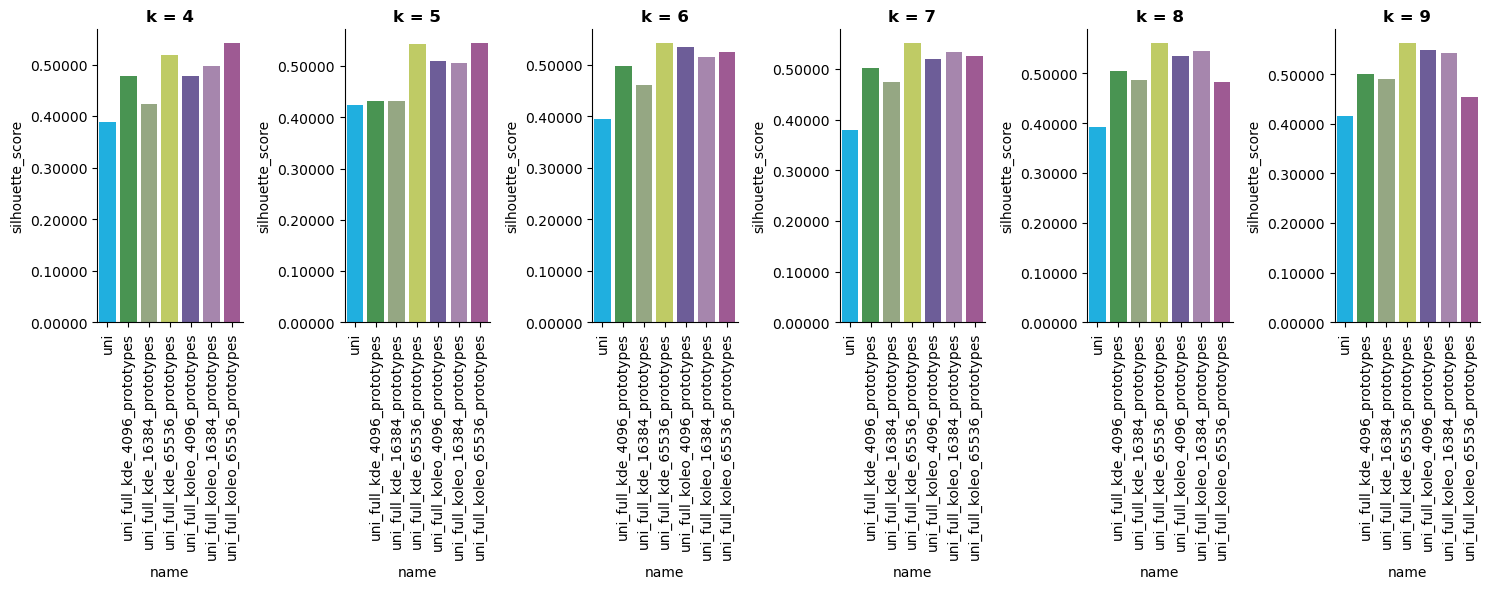

In [107]:
plt.figure(figsize=(15, 6))

for i in range(4, 10):
    plt.subplot(1, 6, i - 4 + 1)
    sns.barplot(data=best_silhouette_scores_ordered[best_silhouette_scores_ordered['n_clusters'] == i], x="name", y="silhouette_score", palette=a)
    sns.despine()
    plt.title(f"k = {i}", weight='bold')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"invasive_cancer_clustering_best_silhouette_scores_bars_{model_type}_models.pdf"), bbox_inches='tight')

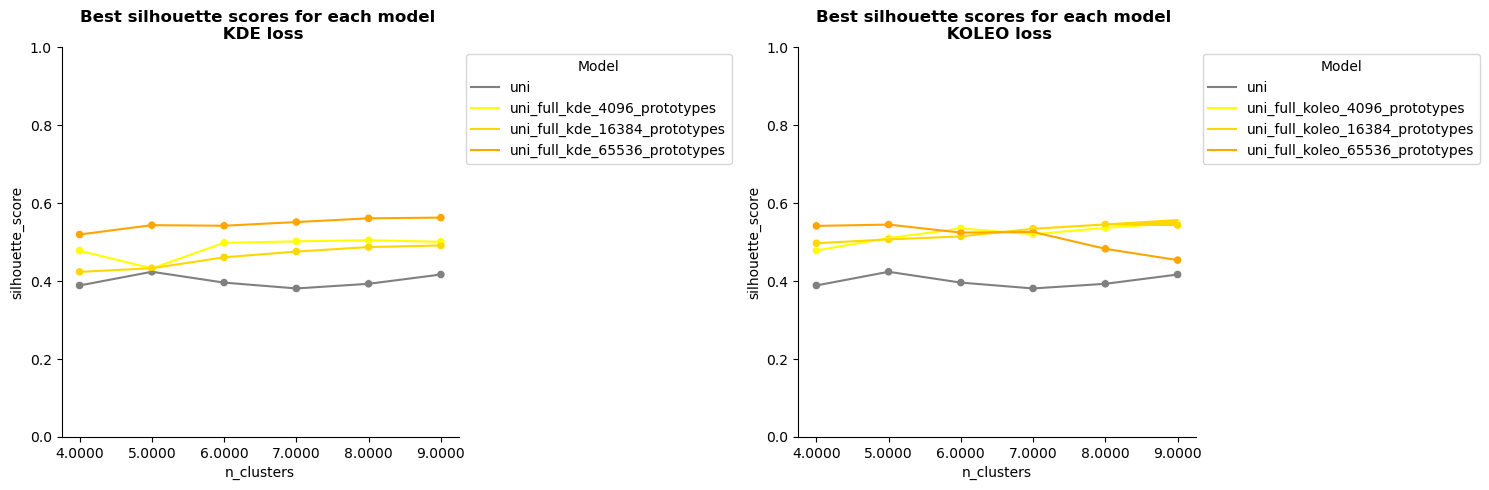

In [108]:
df_all = pd.concat(df_all_clusters)
best_silhouette_scores = df_all.groupby(["name", "n_clusters"])["silhouette_score"].max()
best_silhouette_scores_ordered = best_silhouette_scores.loc[names].reset_index()


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=best_silhouette_scores_ordered[~best_silhouette_scores_ordered['name'].str.contains("koleo")], 
             x="n_clusters", y="silhouette_score", hue="name", palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.scatterplot(data=best_silhouette_scores_ordered[~best_silhouette_scores_ordered['name'].str.contains("koleo")], 
                x="n_clusters", y="silhouette_score", hue="name", legend=False, palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.despine()
plt.title(f"Best silhouette scores for each model \n KDE loss", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
sns.lineplot(data=best_silhouette_scores_ordered[~best_silhouette_scores_ordered['name'].str.contains("kde")], 
             x="n_clusters", y="silhouette_score", hue="name", palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.scatterplot(data=best_silhouette_scores_ordered[~best_silhouette_scores_ordered['name'].str.contains("kde")], 
                x="n_clusters", y="silhouette_score", hue="name", legend=False, palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.despine()
plt.title(f"Best silhouette scores for each model \n KOLEO loss", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, 1)

plt.tight_layout()

plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"invasive_cancer_clustering_best_silhouette_scores_{model_type}_models_kde_vs_koleo.pdf"), bbox_inches='tight')

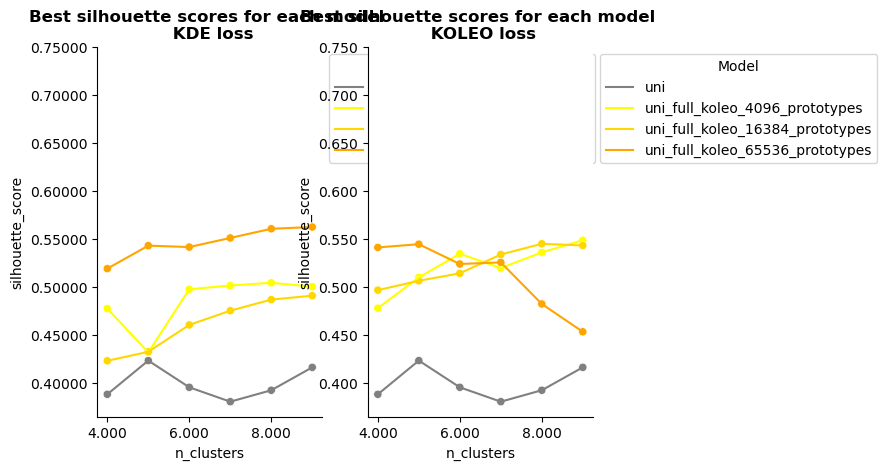

In [109]:
best_silhouette_scores_ordered_4 = best_silhouette_scores_ordered[best_silhouette_scores_ordered['n_clusters'] >= 4]

plt.subplot(1, 2, 1)
sns.lineplot(data=best_silhouette_scores_ordered_4[~best_silhouette_scores_ordered_4['name'].str.contains("koleo")], 
             x="n_clusters", y="silhouette_score", hue="name", palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.scatterplot(data=best_silhouette_scores_ordered_4[~best_silhouette_scores_ordered_4['name'].str.contains("koleo")], 
                x="n_clusters", y="silhouette_score", hue="name", legend=False, palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.despine()
plt.title(f"Best silhouette scores for each model \n KDE loss", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0.365, 0.75)

plt.subplot(1, 2, 2)
sns.lineplot(data=best_silhouette_scores_ordered_4[~best_silhouette_scores_ordered_4['name'].str.contains("kde")], 
             x="n_clusters", y="silhouette_score", hue="name", palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.scatterplot(data=best_silhouette_scores_ordered_4[~best_silhouette_scores_ordered_4['name'].str.contains("kde")], 
                x="n_clusters", y="silhouette_score", hue="name", legend=False, palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.despine()
plt.title(f"Best silhouette scores for each model \n KOLEO loss", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0.365, 0.75)

plt.tight_layout()

plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"invasive_cancer_clustering_best_silhouette_scores_{model_type}_models_kde_vs_koleo_min_4_clusters.pdf"), bbox_inches='tight')

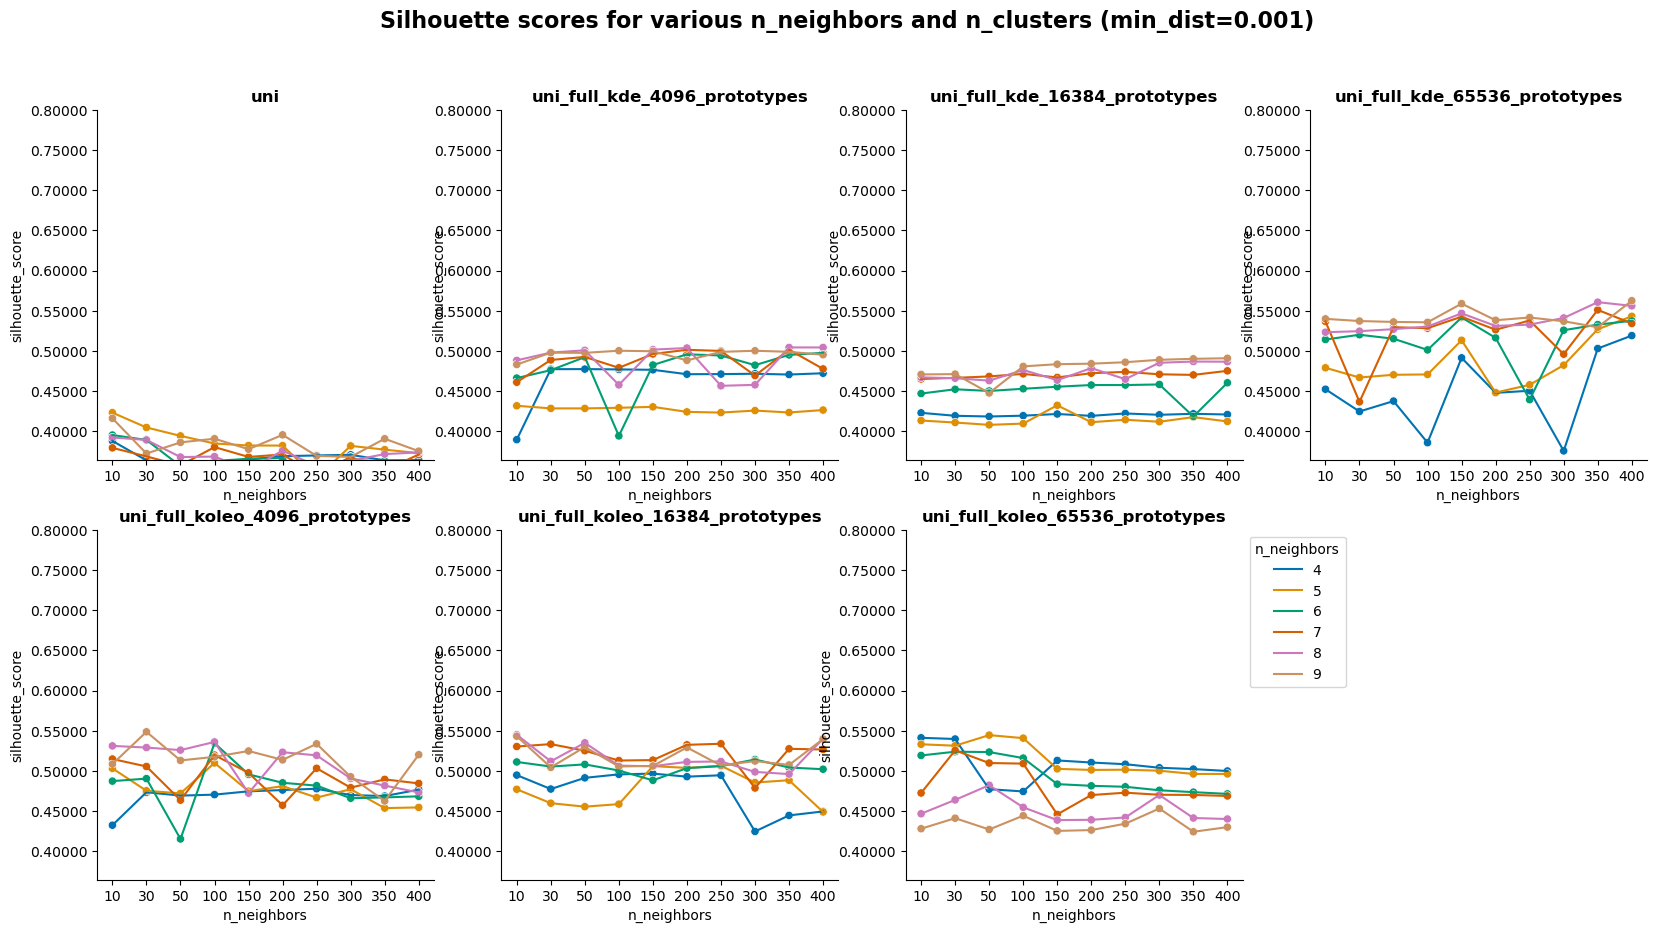

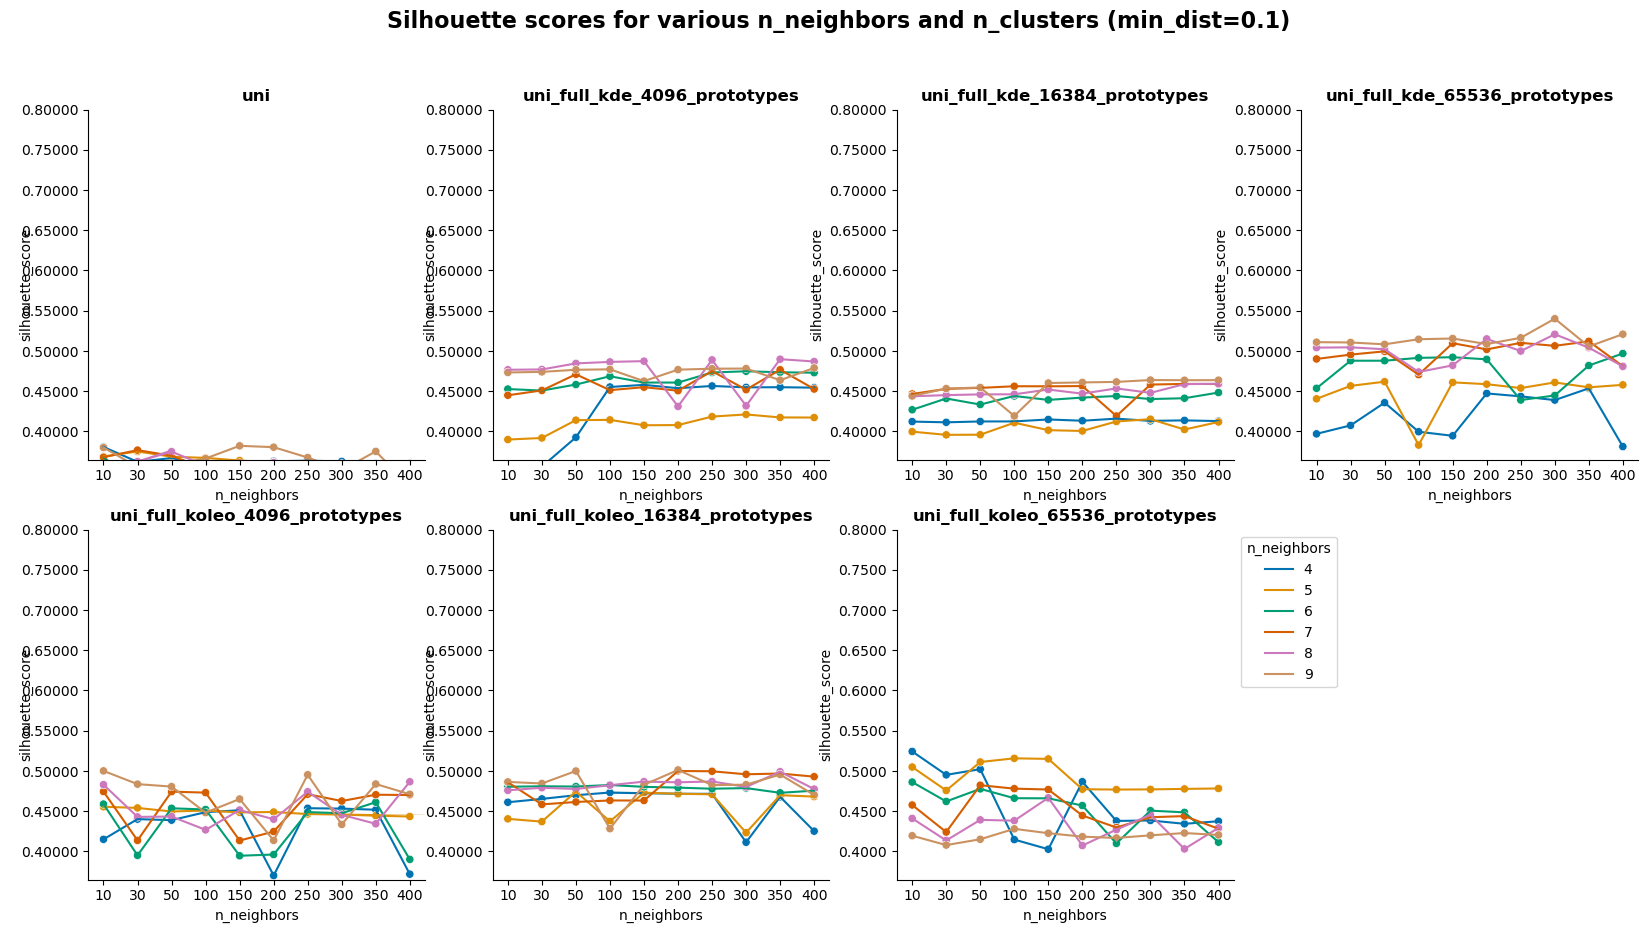

In [110]:
for min_dist in [0.001, 0.1]:
    plt.figure(figsize=(20, 10))
    for i, name in enumerate(names):
        plt.subplot(2, int(np.ceil(len(names)/2)), i + 1)
        dfs_clusters = []
        for k in [ 4, 5, 6, 7, 8, 9]:
        # for k in [5]:
            with open(f"{path}/{name}/scores_umap_across_parameters_{k}_clusters.json") as f:
                model_clusters = json.load(f)
                
                df_model_clusters = pd.DataFrame(model_clusters[str(min_dist)]).T
                df_model_clusters = df_model_clusters.reset_index().rename(columns={"index": "n_neighbors"})
                df_model_clusters["n_clusters"] = k
                dfs_clusters.append(df_model_clusters)
                
        dfs_clusters = pd.concat(dfs_clusters)      
          

        sns.scatterplot(data=dfs_clusters, y="silhouette_score", x='n_neighbors', hue='n_clusters', palette='colorblind', legend=False)
        sns.lineplot(data=dfs_clusters, y="silhouette_score", x='n_neighbors', hue='n_clusters', palette='colorblind')
        sns.despine()

        plt.title(name, weight='bold')

        plt.suptitle(f"Silhouette scores for various n_neighbors and n_clusters (min_dist={min_dist})", 
                    weight='bold', 
                    fontsize=16)   
        
        
        if i != len(names) - 1:
            plt.legend().remove()
        else:
            plt.legend(title="n_neighbors", loc='upper left', bbox_to_anchor=(1, 1))
            
        plt.ylim(0.365, 0.8)

In [111]:
names

['uni',
 'uni_full_kde_4096_prototypes',
 'uni_full_kde_16384_prototypes',
 'uni_full_kde_65536_prototypes',
 'uni_full_koleo_4096_prototypes',
 'uni_full_koleo_16384_prototypes',
 'uni_full_koleo_65536_prototypes']

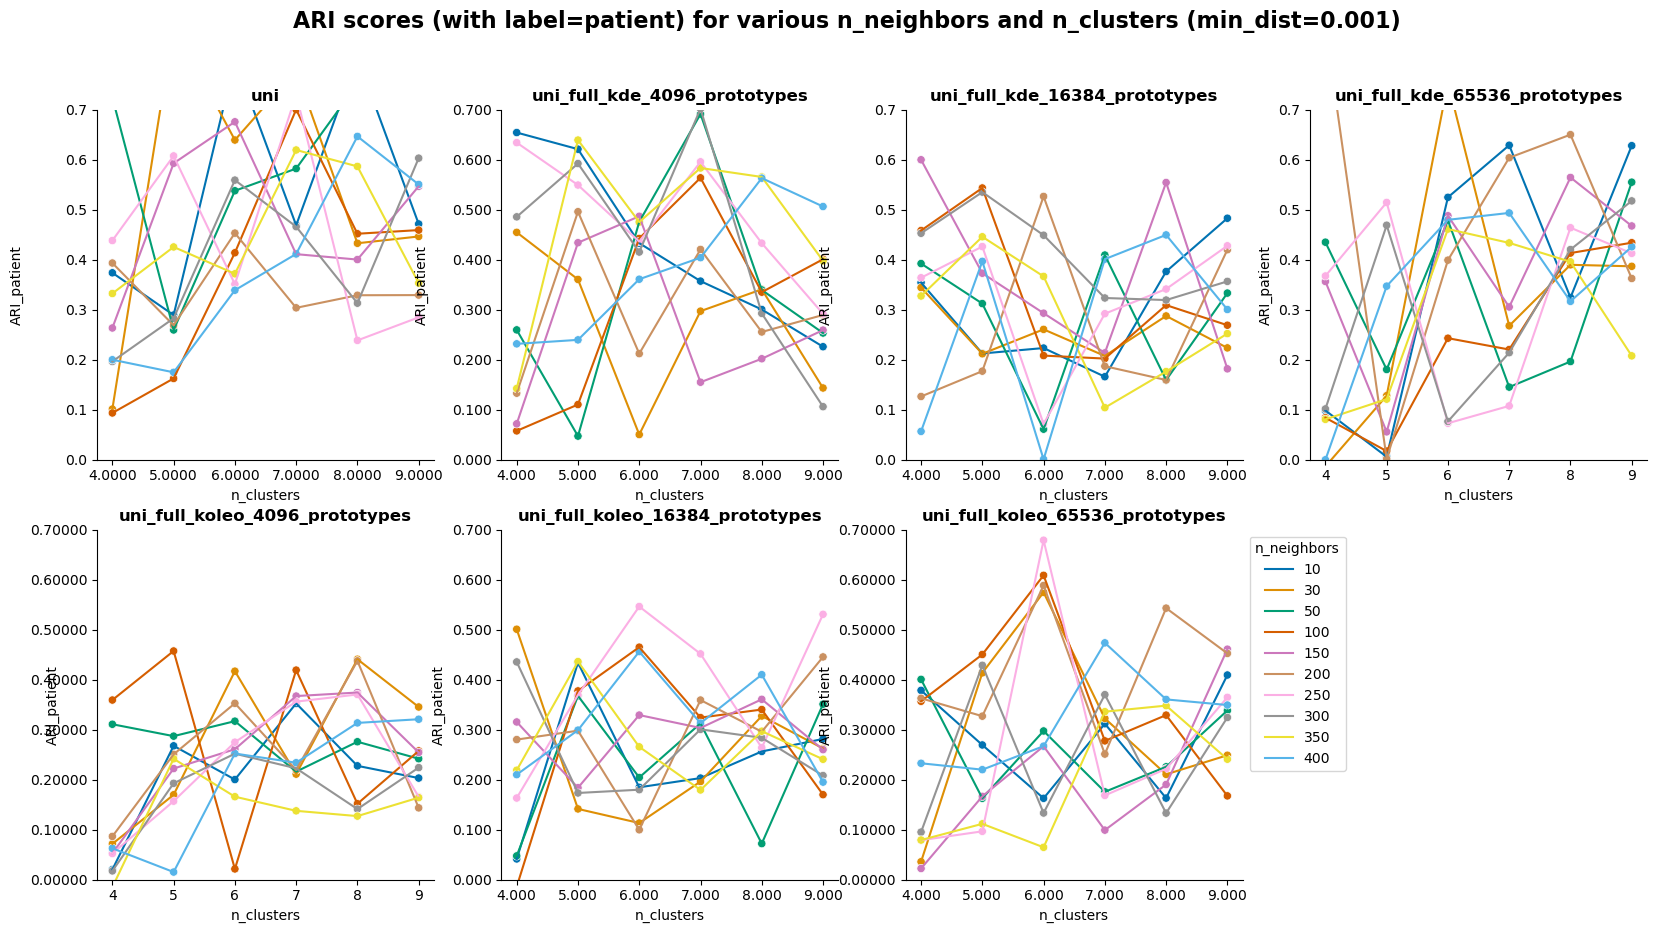

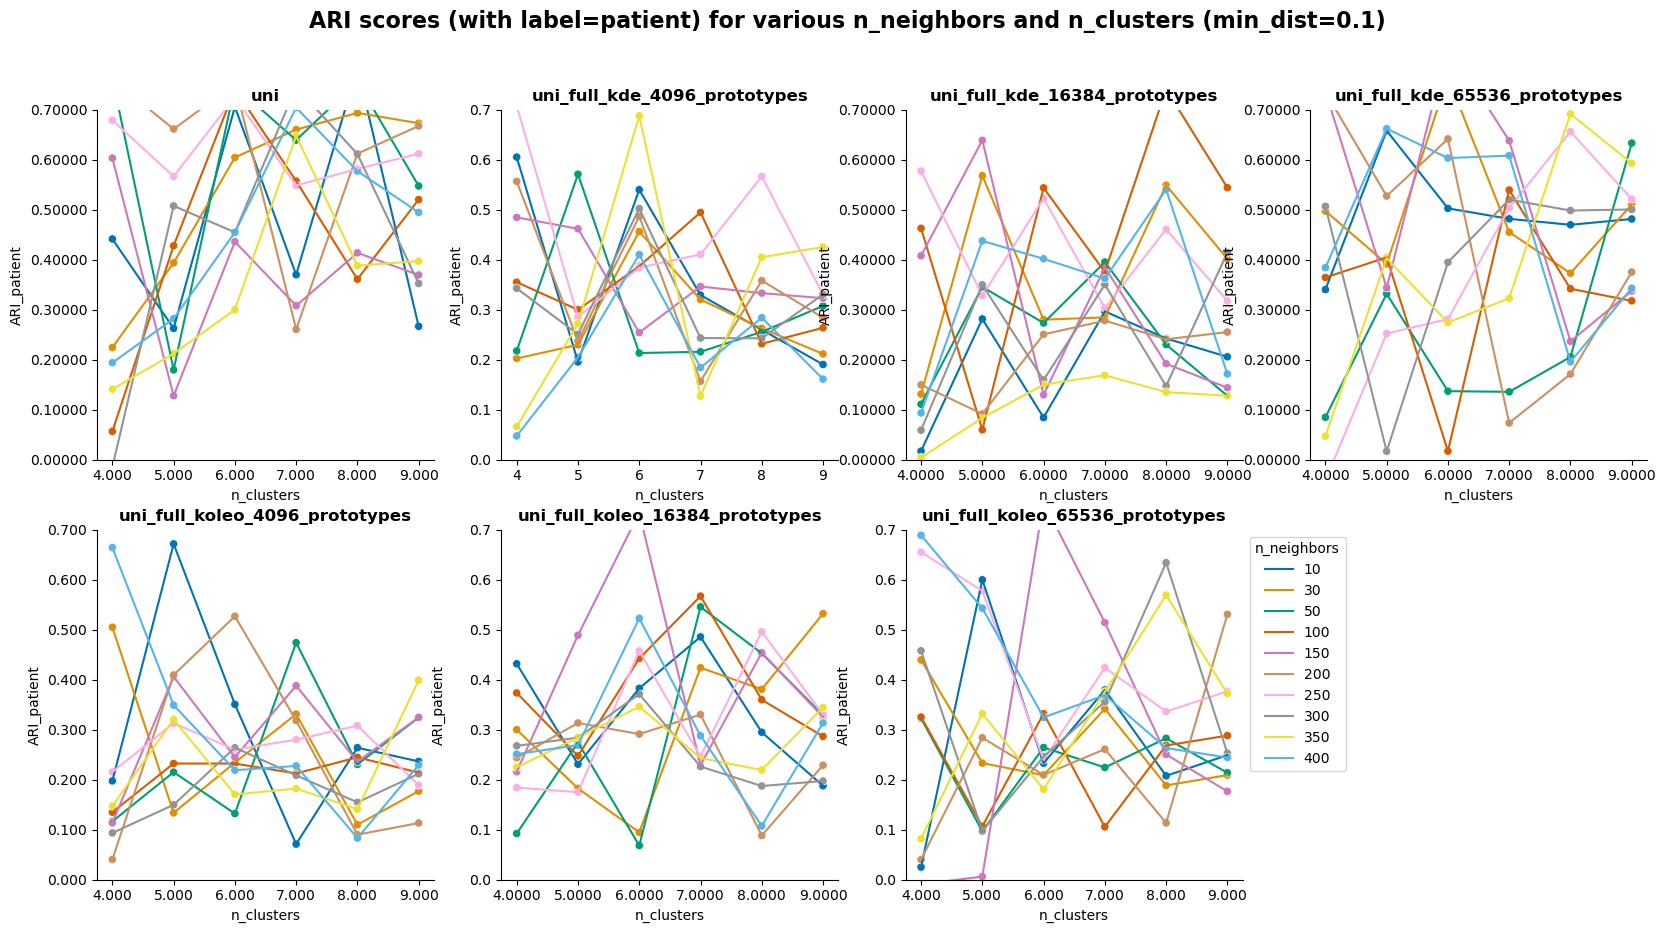

In [112]:
from sklearn.metrics import adjusted_rand_score

df_all_clusters = []
for min_dist in [0.001, 0.1]:
    # df_all_clusters = []

    plt.figure(figsize=(20, 10))
    for i, name in enumerate(names):
        plt.subplot(2, int(np.ceil(len(names) / 2)), i + 1)
        dfs_clusters = []

        for k in [4, 5, 6, 7, 8, 9]:
        # for k in [5]:
            with open(f"{path}/{name}/scores_umap_across_parameters_{k}_clusters.json") as f:
                model_clusters = json.load(f)
                
                model_clusters['patient_label'] = [x.split('_')[0] for x in model_clusters['samples']]
                # Convert labels to integers
                # model_clusters['patient_label_int'] = [ord(label) - ord('A') - 1 for label in model_clusters['patient_label']]
                # unique_labels = sorted(set(model_clusters['patient_label']))
                # label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
                # model_clusters['patient_label_int'] = [label_to_int[label] for label in model_clusters['patient_label']]
                
                df_model_clusters = pd.DataFrame(model_clusters[str(min_dist)]).T
                df_model_clusters = df_model_clusters.reset_index().rename(columns={"index": "n_neighbors"})
                
                df_model_clusters["n_clusters"] = k
                # df_model_clusters["ARI_patient"] = df_model_clusters['labels'].apply(lambda x: adjusted_rand_score(model_clusters['patient_label_int'], x))
                dfs_clusters.append(df_model_clusters)
                        
        dfs_clusters = pd.concat(dfs_clusters) 
        dfs_clusters["name"] = name
        dfs_clusters["min_dist"] = min_dist
        df_all_clusters.append(dfs_clusters)    
        
        sns.scatterplot(data=dfs_clusters, y="ARI_patient", x='n_clusters', hue='n_neighbors', palette='colorblind', legend=False)
        sns.lineplot(data=dfs_clusters, y="ARI_patient", x='n_clusters', hue='n_neighbors', palette='colorblind')
        sns.despine()

        plt.title(name, weight='bold')

        plt.suptitle(f"ARI scores (with label=patient) for various n_neighbors and n_clusters (min_dist={min_dist})", 
                    weight='bold', 
                    fontsize=16)   
        
        
        if i != len(names) - 1:
            plt.legend().remove()
        else:
            plt.legend(title="n_neighbors", loc='upper left', bbox_to_anchor=(1, 1))
            
        plt.ylim(0, 0.7)
        
    plt.savefig(os.path.join(config['figures_folder'], f"Figure4/invasive_cancer_clustering_ARI_scores_patient_various_neighbors_mindist_{min_dist}_{model_type}_models.pdf"), bbox_inches='tight')
                

In [113]:
df_all = pd.concat(df_all_clusters)
df_all

,n_neighbors,data,labels,cluster_number,silhouette_score,inertia,davies_bouldin_score,calinski_harabasz_score,ARI_patient,n_clusters,name,min_dist
0,10,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...",4,0.388199,324367.861117,0.898443,41692.545435,0.373526,4,uni,0.001
1,30,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...",4,0.364028,199224.437648,0.929864,39032.419714,0.100949,4,uni,0.001
2,50,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...",4,0.352843,167748.549272,0.952111,38855.025105,0.724089,4,uni,0.001
3,100,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0.36176,134852.599844,0.930084,39976.052341,0.09319,4,uni,0.001
4,150,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0.364999,118183.279787,0.927719,41000.78959,0.263153,4,uni,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...
5,200,umap,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",9,0.418356,36214.180101,0.770922,59559.154827,0.53047,9,uni_full_koleo_65536_prototypes,0.100
6,250,umap,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",9,0.416707,34870.106837,0.775276,58717.393953,0.376438,9,uni_full_koleo_65536_prototypes,0.100
7,300,umap,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",9,0.419959,33616.17228,0.771066,58350.898079,0.252749,9,uni_full_koleo_65536_prototypes,0.100
8,350,umap,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",9,0.422832,35121.390188,0.738306,54178.388575,0.372114,9,uni_full_koleo_65536_prototypes,0.100


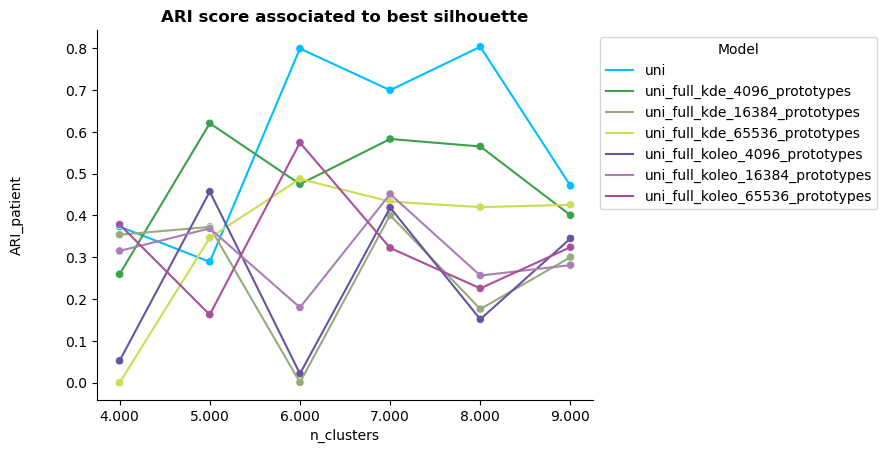

In [114]:
df_all = pd.concat(df_all_clusters)

df_all["silhouette_score"] = pd.to_numeric(df_all["silhouette_score"], errors='coerce')

# Drop rows where silhouette_score could not be converted to numeric
df_all = df_all.dropna(subset=["silhouette_score"]).reset_index(drop=True)

# Group by 'name' and 'n_clusters' and get the index of the maximum 'silhouette_score'
idx = df_all.groupby(["name", "n_clusters"])["silhouette_score"].idxmax()



best_silhouette_scores = df_all.loc[idx]


best_silhouette_scores_ordered = best_silhouette_scores.set_index("name").loc[names].reset_index()

sns.scatterplot(data=best_silhouette_scores_ordered, x="n_clusters", y="ARI_patient", hue="name", legend=False, palette=a)
sns.lineplot(data=best_silhouette_scores_ordered, x="n_clusters", y="ARI_patient", hue="name", palette=a)
sns.despine()
plt.title("ARI score associated to best silhouette", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(os.path.join(config['figures_folder'], f"Figure4/invasive_cancer_clustering_ARI_patient_associated_with_best_silhouette_scores_{model_type}_models.pdf"), bbox_inches='tight')

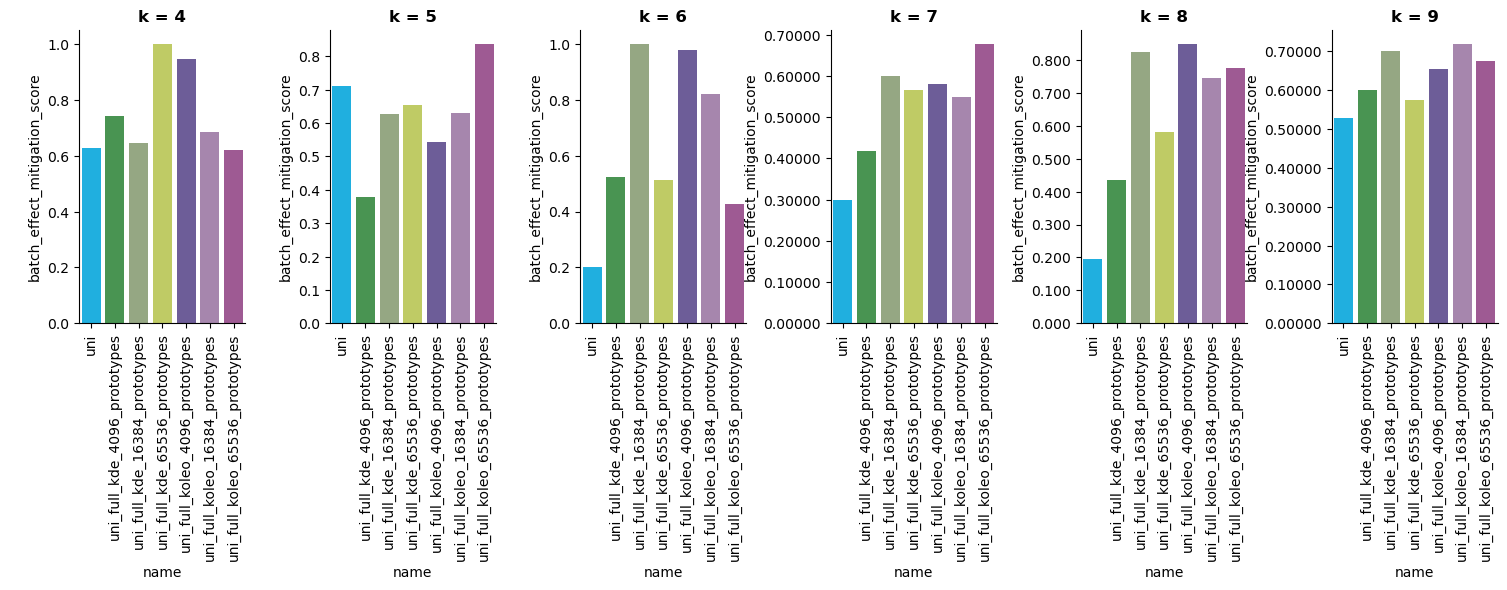

In [115]:
plt.figure(figsize=(15, 6))
best_silhouette_scores_ordered['batch_effect_mitigation_score'] = 1 - best_silhouette_scores_ordered['ARI_patient']
for i in range(4, 10):
    plt.subplot(1, 6, i - 4 + 1)
    sns.barplot(data=best_silhouette_scores_ordered[best_silhouette_scores_ordered['n_clusters'] == i], x="name", y="batch_effect_mitigation_score", palette=a)
    sns.despine()
    plt.title(f"k = {i}", weight='bold')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(os.path.join(config['figures_folder'], f"Figure4/invasive_cancer_clustering_ARI_patient_associated_with_best_silhouette_scores_bars_{model_type}_models.pdf"), bbox_inches='tight')

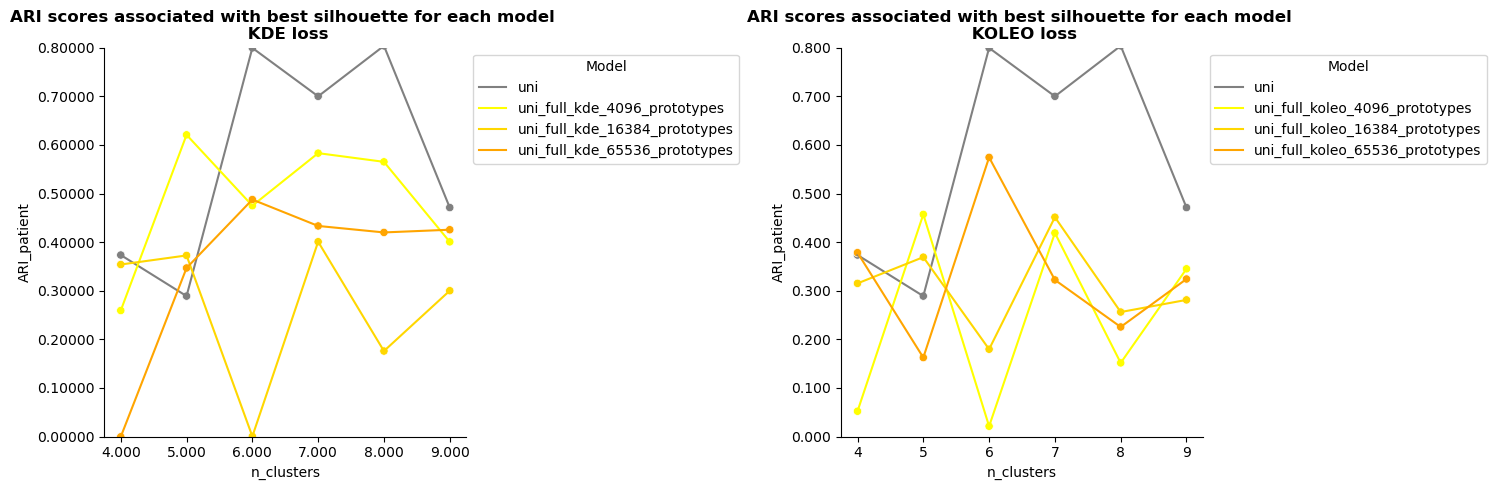

In [116]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=best_silhouette_scores_ordered[~best_silhouette_scores_ordered['name'].str.contains("koleo")], 
             x="n_clusters", y="ARI_patient", hue="name", palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.scatterplot(data=best_silhouette_scores_ordered[~best_silhouette_scores_ordered['name'].str.contains("koleo")], 
                x="n_clusters", y="ARI_patient", hue="name", legend=False, palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.despine()
plt.title(f"ARI scores associated with best silhouette for each model \n KDE loss", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, 0.8)

plt.subplot(1, 2, 2)
sns.lineplot(data=best_silhouette_scores_ordered[~best_silhouette_scores_ordered['name'].str.contains("kde")], 
             x="n_clusters", y="ARI_patient", hue="name", palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.scatterplot(data=best_silhouette_scores_ordered[~best_silhouette_scores_ordered['name'].str.contains("kde")], 
                x="n_clusters", y="ARI_patient", hue="name", legend=False, palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.despine()
plt.title(f"ARI scores associated with best silhouette for each model \n KOLEO loss", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, 0.8)

plt.tight_layout()

plt.savefig(os.path.join(config['figures_folder'], f"Figure4/invasive_cancer_clustering_ARI_patient_associated_with_best_silhouette_scores_{model_type}_models_kde_vs_koleo.pdf"), bbox_inches='tight')

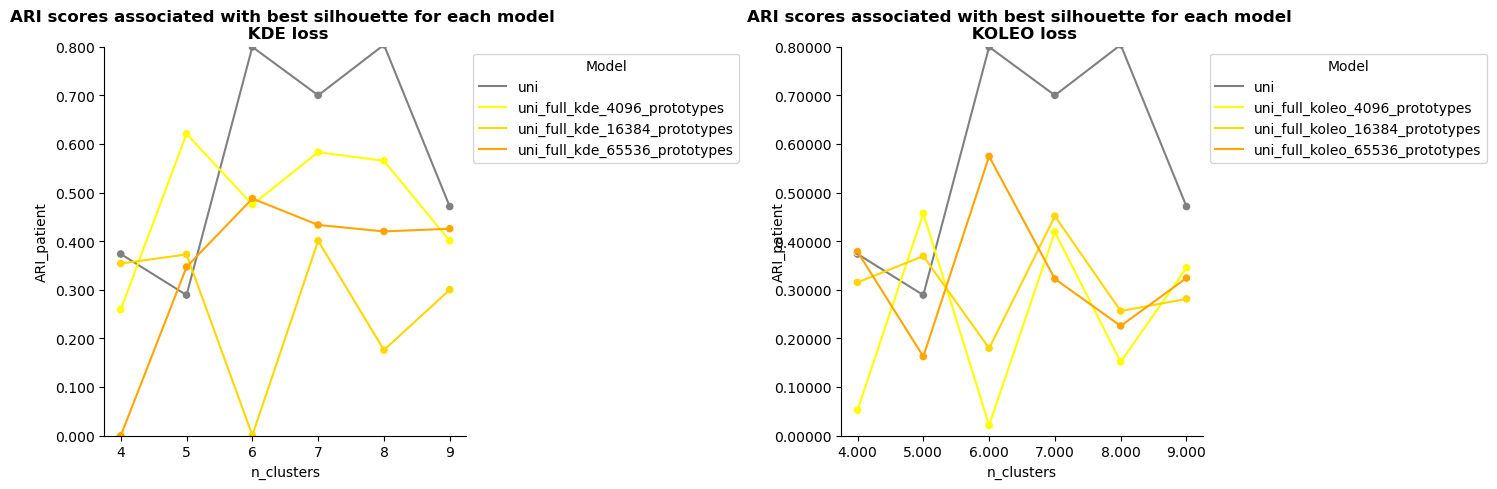

In [117]:
best_silhouette_scores_ordered_4 = best_silhouette_scores_ordered[best_silhouette_scores_ordered['n_clusters'] >= 4]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=best_silhouette_scores_ordered_4[~best_silhouette_scores_ordered_4['name'].str.contains("koleo")], 
             x="n_clusters", y="ARI_patient", hue="name", palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.scatterplot(data=best_silhouette_scores_ordered_4[~best_silhouette_scores_ordered_4['name'].str.contains("koleo")], 
                x="n_clusters", y="ARI_patient", hue="name", legend=False, palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.despine()
plt.title(f"ARI scores associated with best silhouette for each model \n KDE loss", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, 0.8)

plt.subplot(1, 2, 2)
sns.lineplot(data=best_silhouette_scores_ordered_4[~best_silhouette_scores_ordered_4['name'].str.contains("kde")], 
             x="n_clusters", y="ARI_patient", hue="name", palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.scatterplot(data=best_silhouette_scores_ordered_4[~best_silhouette_scores_ordered_4['name'].str.contains("kde")], 
                x="n_clusters", y="ARI_patient", hue="name", legend=False, palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.despine()
plt.title(f"ARI scores associated with best silhouette for each model \n KOLEO loss", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, 0.8)

plt.tight_layout()

plt.savefig(os.path.join(config['figures_folder'], f"Figure4/invasive_cancer_clustering_ARI_patient_associated_with_best_silhouette_scores_{model_type}_models_kde_vs_koleo_min_4_clusters.pdf"), bbox_inches='tight')

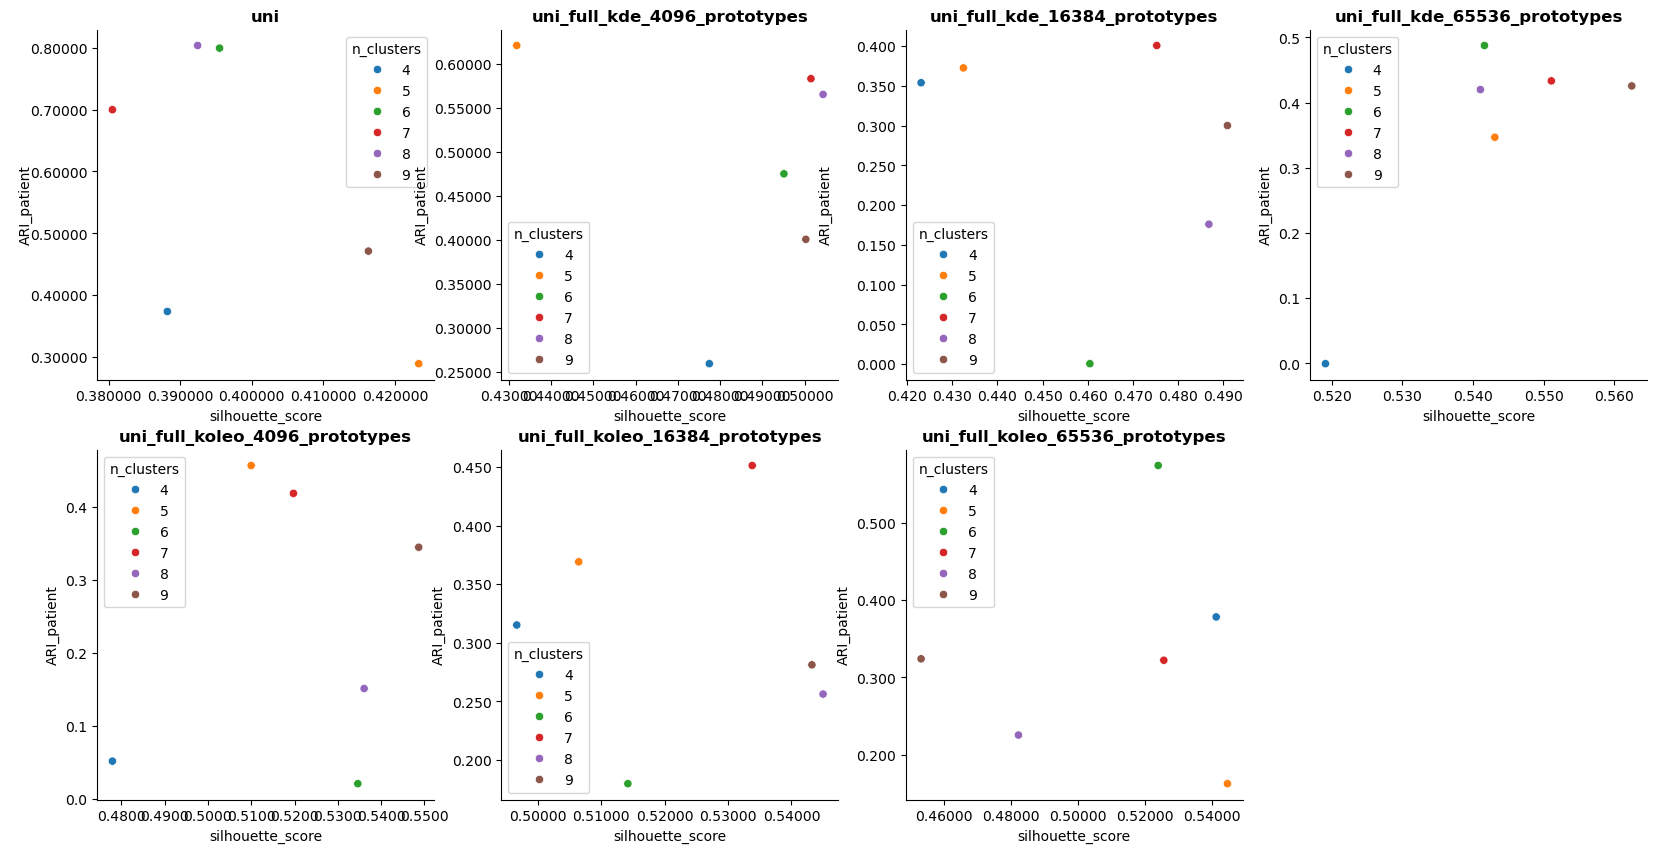

In [118]:
df_sil_ARI = best_silhouette_scores_ordered[['silhouette_score', 'ARI_patient', 'n_clusters', 'name']]

plt.figure(figsize=(20, 10))
for i, name in enumerate(df_sil_ARI['name'].unique()):
    plt.subplot(2, int(np.ceil(len(names)/2)), i + 1)
    sub_df = df_sil_ARI[df_sil_ARI['name'] == name]
    sub_df['n_clusters'] = sub_df['n_clusters'].astype(str)
    sns.scatterplot(sub_df, x='silhouette_score', y='ARI_patient', hue='n_clusters')
    plt.title(name, weight='bold')
    sns.despine()

In [119]:
df_sil_ARI['euclidian_dist_to_optimal'] = df_sil_ARI.apply(lambda row: np.sqrt((row['silhouette_score'] - 1)**2 + (row['ARI_patient'] - 0)**2), axis=1)

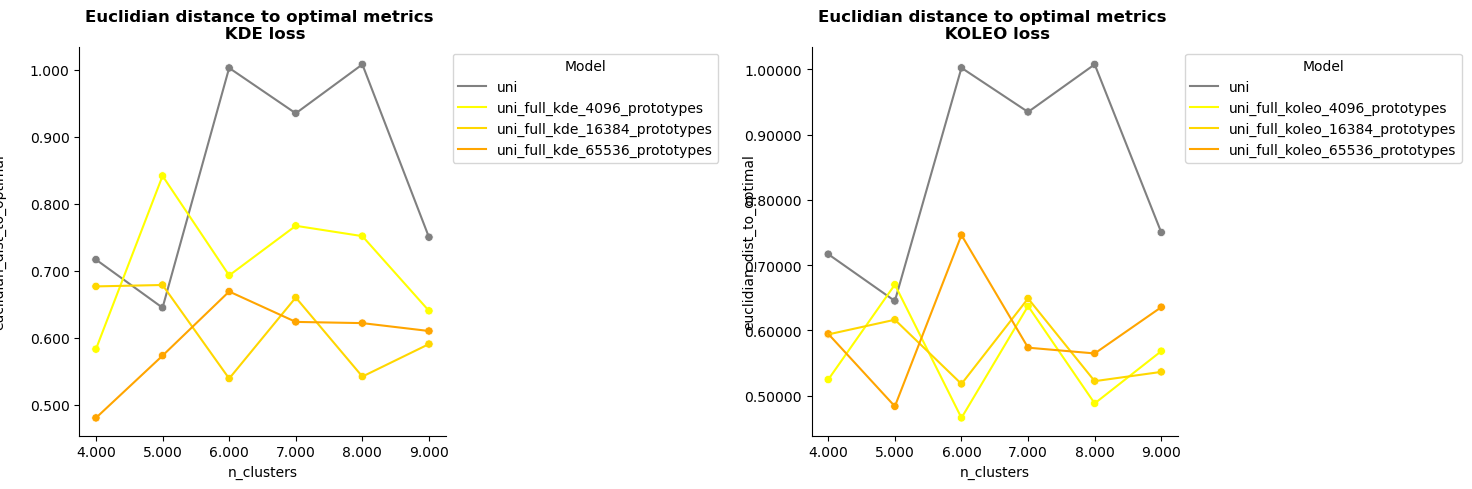

In [120]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=df_sil_ARI[~df_sil_ARI['name'].str.contains("koleo")], 
             x="n_clusters", y="euclidian_dist_to_optimal", hue="name", palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.scatterplot(data=df_sil_ARI[~df_sil_ARI['name'].str.contains("koleo")], 
                x="n_clusters", y="euclidian_dist_to_optimal", hue="name", legend=False, palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.despine()
plt.title(f"Euclidian distance to optimal metrics \n KDE loss", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))

plt.subplot(1, 2, 2)
sns.lineplot(data=df_sil_ARI[~df_sil_ARI['name'].str.contains("kde")], 
             x="n_clusters", y="euclidian_dist_to_optimal", hue="name", palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.scatterplot(data=df_sil_ARI[~df_sil_ARI['name'].str.contains("kde")], 
                x="n_clusters", y="euclidian_dist_to_optimal", hue="name", legend=False, palette=["gray", "yellow", "gold", "orange", "red", "darkred"])
sns.despine()
plt.title(f"Euclidian distance to optimal metrics \n KOLEO loss", weight='bold')
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

plt.savefig(os.path.join(config['figures_folder'], f"Figure4/invasive_cancer_clustering_euclidian_distance_to_optimal_metrics_{model_type}_models_kde_vs_koleo.pdf"), bbox_inches='tight')

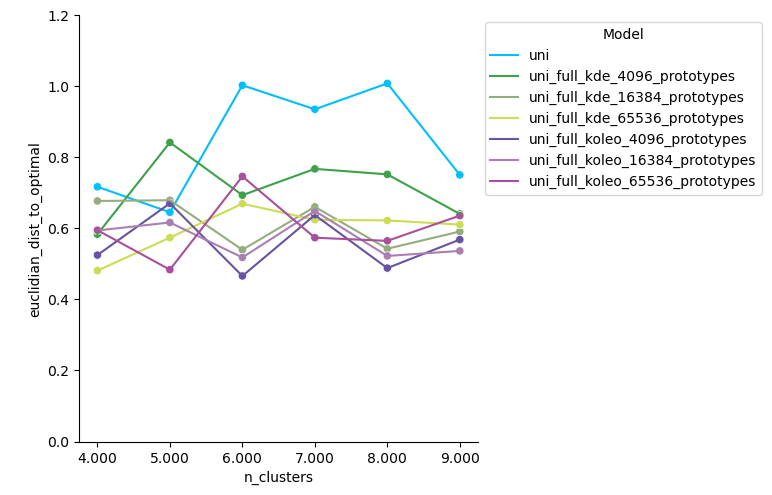

In [121]:
plt.figure(figsize=(8, 5))



sns.lineplot(data=df_sil_ARI, 
             x="n_clusters", y="euclidian_dist_to_optimal", hue="name", palette=a)
sns.scatterplot(data=df_sil_ARI, 
                x="n_clusters", y="euclidian_dist_to_optimal", hue="name", legend=False, palette=a)

plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()
plt.ylim(0, 1.2)
plt.savefig(os.path.join(config['figures_folder'], f"Figure4/invasive_cancer_clustering_euclidian_distance_to_optimal_metrics_{model_type}_min_4_clusters.pdf"), bbox_inches='tight')

In [123]:
df_sil_ARI.loc[df_sil_ARI.groupby("name")["euclidian_dist_to_optimal"].idxmin()]

,silhouette_score,ARI_patient,n_clusters,name,euclidian_dist_to_optimal
1,0.423326,0.289026,5,uni,0.645050
14,0.460478,0.000482,6,uni_full_kde_16384_prototypes,0.539522
6,0.477463,0.259346,4,uni_full_kde_4096_prototypes,0.583357
18,0.519095,-0.000453,4,uni_full_kde_65536_prototypes,0.480905
32,0.514222,0.17973,6,uni_full_koleo_16384_prototypes,0.517961
26,0.534600,0.021262,6,uni_full_koleo_4096_prototypes,0.465886
36,0.541218,0.378366,4,uni_full_koleo_65536_prototypes,0.594678


In [124]:
opti_clusters = df_sil_ARI.loc[df_sil_ARI.groupby("name")["euclidian_dist_to_optimal"].idxmin()].set_index("name")
opti_clusters.loc["uni", "n_clusters"]
opti_clusters

,silhouette_score,ARI_patient,n_clusters,euclidian_dist_to_optimal
name,,,,
uni,0.423326,0.289026,5,0.645050
uni_full_kde_16384_prototypes,0.460478,0.000482,6,0.539522
uni_full_kde_4096_prototypes,0.477463,0.259346,4,0.583357
uni_full_kde_65536_prototypes,0.519095,-0.000453,4,0.480905
uni_full_koleo_16384_prototypes,0.514222,0.17973,6,0.517961
uni_full_koleo_4096_prototypes,0.534600,0.021262,6,0.465886
uni_full_koleo_65536_prototypes,0.544562,0.162561,5,0.483580


In [125]:

opti_clusters.to_csv(os.path.join(path, "optimal_clusters.csv"))

In [126]:
opti_clusters

,silhouette_score,ARI_patient,n_clusters,euclidian_dist_to_optimal
name,,,,
uni,0.423326,0.289026,5,0.645050
uni_full_kde_16384_prototypes,0.460478,0.000482,6,0.539522
uni_full_kde_4096_prototypes,0.477463,0.259346,4,0.583357
uni_full_kde_65536_prototypes,0.519095,-0.000453,4,0.480905
uni_full_koleo_16384_prototypes,0.514222,0.17973,6,0.517961
uni_full_koleo_4096_prototypes,0.534600,0.021262,6,0.465886
uni_full_koleo_65536_prototypes,0.544562,0.162561,5,0.483580
